In [1]:
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

Merge left mask and right mask 

In [2]:
def plot_lung_segment(ax, image, mask):
    ax.imshow(image)
    ax.imshow(mask, alpha=0.4)
    ax.set_axis_off()
    
def plot_sample(path, image_dn, mask_dn, image_names, jsrt=False):
    """
    image_names: list of 16 random cxr
    """
    fig, axes = plt.subplots(4, 4, figsize=(12, 10))
    for i, ax,  in enumerate(axes.flat):
        image_name = image_names[i]
        image = Image.open(path/image_dn/image_name)
        mask = Image.open(path/mask_dn/image_name)
        
        if jsrt:
            # jsrt mask (csr dataset) 
            # is not the same size as image (original jsrt dataset) :v 
            mask = mask.resize(image.size)
        
        plot_lung_segment(ax, image, mask)
    plt.tight_layout(pad=0.1)
    
def check_range(path, image_dn, mask_dn, image_name):
    image = np.array(Image.open(path/image_dn/image_name))
    mask = np.array(Image.open(path/mask_dn/image_name))
    print(f'Image: {image.min()}, {image.max()}')
    print(f'Mask: {mask.min()}, {mask.max()}')

# Montgomery

In [3]:
PATH = Path('/mnt/data/xray-thesis/data/Montgomery')
LEFT_MASK_DN = 'ManualMask/leftMask'
RIGHT_MASK_DN = 'ManualMask/rightMask'
MASK_DN = 'masks'
IMAGE_DN = 'images'

image_name = 'MCUCXR_0001_0.png'
all_images = [p.parts[-1] for p in (PATH/MASK_DN).iterdir()]
image_names = random.sample(all_images, 16)

### merge left and right lung

In [113]:
for image_path in (PATH/IMAGE_DN).iterdir():
    image_file = image_path.parts[-1]
    if 'png' not in image_file:
        continue

    right_mask = np.array(Image.open(PATH/RIGHT_MASK_DN/image_file)) # 1-bit grayscale
    left_mask = np.array(Image.open(PATH/LEFT_MASK_DN/image_file)) # 1-bit grayscale
    mask = (np.logical_or(right_mask, left_mask) * 255).astype(np.uint8) # 0, 1, bool
    mask = Image.fromarray(mask)
    mask.save(PATH/MASK_DN/image_file) # 8bit grayscale, [0, 255]

### visualisze

In [4]:
check_range(PATH, IMAGE_DN, MASK_DN, all_images[0])

Image: 0, 255
Mask: 0, 255


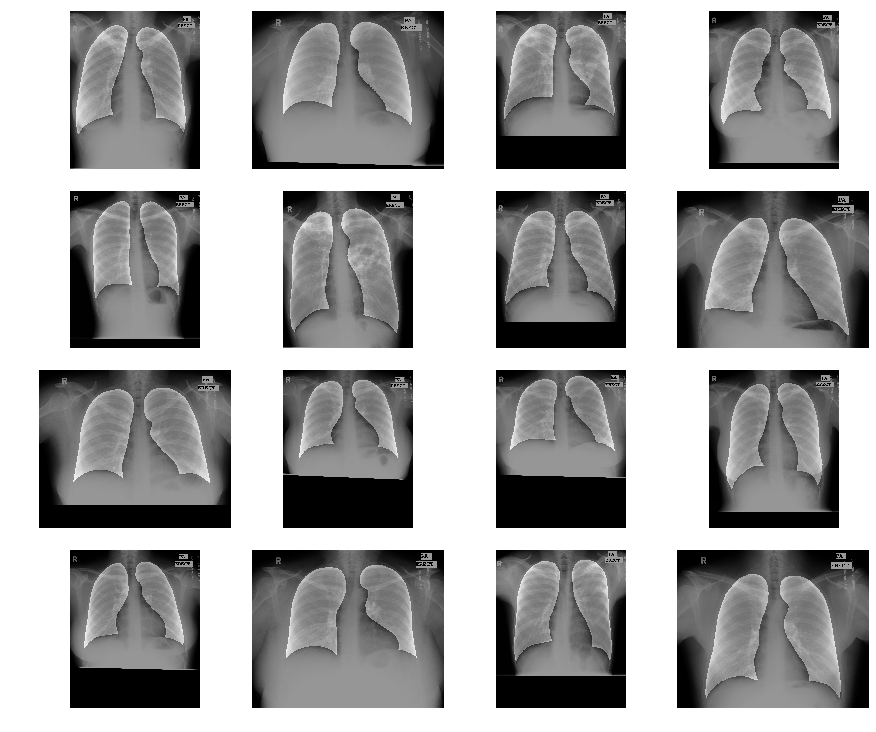

In [5]:
plot_sample(PATH, IMAGE_DN, MASK_DN, image_names)

# JSRT 

In [6]:
from skimage import io, exposure
import cv2

In [7]:
PATH = Path('/mnt/data/xray-thesis/data/JSRT')
LEFT_MASK_DN = 'scr/ManualMasks/leftMask'
RIGHT_MASK_DN = 'scr/ManualMasks/rightMask'

MASK_DN = 'masks'
IMAGE_DN = 'images'

all_images = [p.parts[-1] for p in (PATH/MASK_DN).iterdir()]
image_names = random.sample(all_images, 16)

### preprocess images

In [177]:
for file_path in (PATH/'All247images').iterdir():
    # big endian (>) 12 bit (2*8=16) unsigned integer (u)
    image = 1.0 - np.fromfile(str(file_path), dtype='>u2').reshape((2048, 2048)) * 1. / 4096 
    image = exposure.equalize_hist(image)
    image = (image * 255).astype(np.uint8)
    image = Image.fromarray(image)
    image.save(PATH/IMAGE_DN/f'{file_path.stem}.png')

### merge left and right lung

In [180]:
for image_path in (PATH/'All247images').iterdir():
    image_name = image_path.stem

    right_mask = np.array(Image.open(PATH/RIGHT_MASK_DN/f'{image_name}.gif')) # 1-bit grayscale
    left_mask = np.array(Image.open(PATH/LEFT_MASK_DN/f'{image_name}.gif')) # 1-bit grayscale
     
    mask = (np.logical_or(right_mask, left_mask) * 255).astype(np.uint8) 
    mask = Image.fromarray(mask)
    mask.save(PATH/MASK_DN/f'{image_name}.png')
      
#     plt.imshow(mask)
#     print(image_name)

### visualize

In [8]:
check_range(PATH, IMAGE_DN, MASK_DN, all_images[0])

Image: 6, 255
Mask: 0, 255


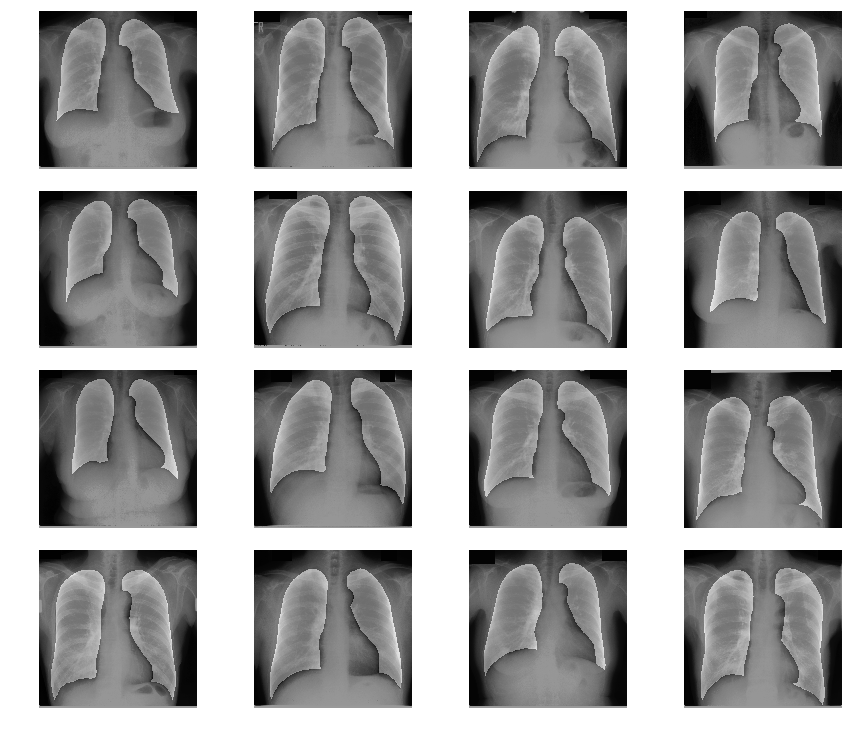

In [9]:
plot_sample(PATH, IMAGE_DN, MASK_DN, image_names, True)

# Shenzhen dataset

### Visualize

In [10]:
PATH = Path('/mnt/data/xray-thesis/data/Shenzhen')

MASK_DN = 'masks' # 556
IMAGE_DN = 'images' # 663 

all_images = [p.parts[-1] for p in (PATH/MASK_DN).iterdir()]
image_names = random.sample(all_images, 16)

In [11]:
check_range(PATH, IMAGE_DN, MASK_DN, all_images[0])

Image: 0, 255
Mask: 0, 255


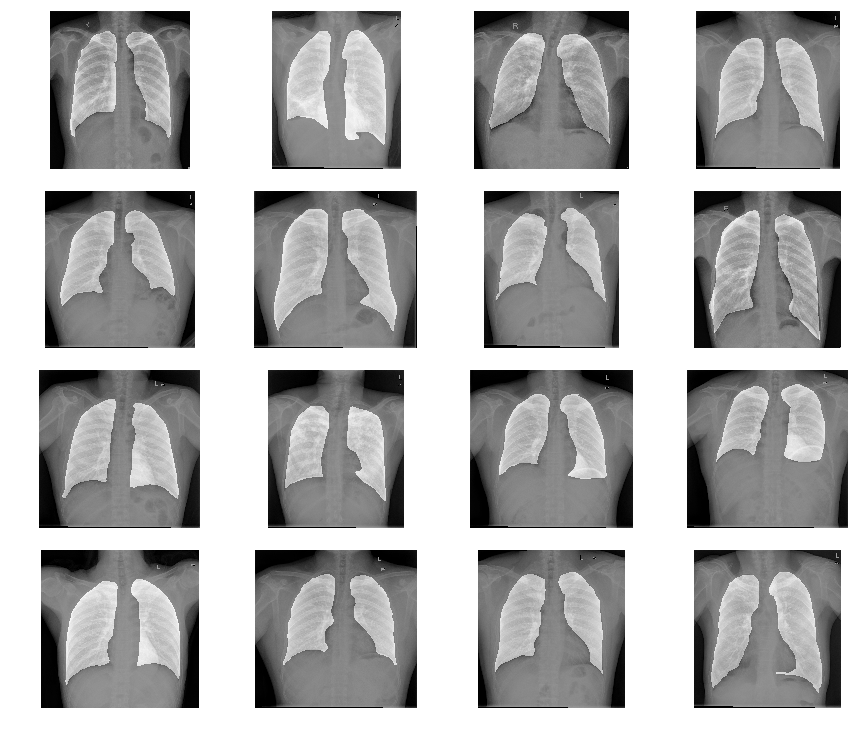

In [13]:
plot_sample(PATH, IMAGE_DN, MASK_DN, image_names)

# RSNA

[This guy](https://github.com/limingwu8/Lung-Segmentation) has manually annotate 1000 rsna images

In [17]:
PATH = Path('/mnt/data/xray-thesis/data/rsna')

MASK_DN = 'masks'
IMAGE_DN = 'images' 

all_images = [p.parts[-1] for p in (PATH/MASK_DN).iterdir()]
image_names = random.sample(all_images, 16)

In [15]:
check_range(PATH, IMAGE_DN, MASK_DN, all_images[0])

Image: 0, 255
Mask: 0, 255


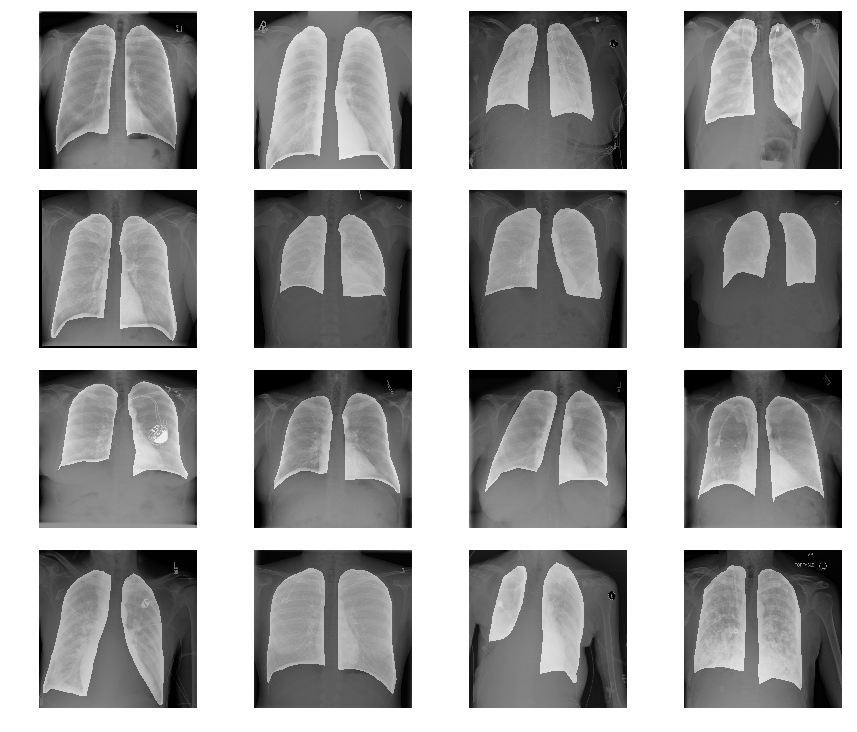

In [18]:
plot_sample(PATH, IMAGE_DN, MASK_DN, image_names)

## Train Val Test Split

In [19]:
import pandas as pd
import random

In [33]:
PATH = Path('/home/dattran/data/xray-thesis/LungSegmentation')

In [21]:
montgometry_images_name = []
for image_path in Path('/mnt/data/xray-thesis/data/Montgomery/images').iterdir():
    if 'png' in image_path.parts[-1]: montgometry_images_name.append(image_path.parts[-1])
        
jsrt_images_name = []
for image_path in Path('/mnt/data/xray-thesis/data/JSRT/images').iterdir():
    jsrt_images_name.append(image_path.parts[-1])
    
shenzhen_images_name = []
for image_path in Path('/mnt/data/xray-thesis/data/Shenzhen/masks').iterdir(): # shenzhen mask is not completed
    shenzhen_images_name.append(image_path.parts[-1])
    
rsna_images_name = []
for image_path in Path('/mnt/data/xray-thesis/data/rsna/images').iterdir(): 
    rsna_images_name.append(image_path.parts[-1])

In [39]:
n = len(montgometry_images_name)
train_mont, val_mont, test_mont = np.split(montgometry_images_name, [int(0.7*n), int(0.8*n)])
print(len(train_mont) + len(val_mont) + len(test_mont) == n) 
n = len(jsrt_images_name)
train_jsrt, val_jsrt, test_jsrt = np.split(jsrt_images_name, [int(0.7*n), int(0.8*n)])
print(len(train_jsrt) + len(val_jsrt) + len(test_jsrt) == n) 
n = len(shenzhen_images_name)
train_shenzhen, val_shenzen = np.split(shenzhen_images_name, [int(0.8*n)])
print(len(train_shenzhen) + len(val_shenzen) == n)
n = len(rsna_images_name)
train_rsna, val_rsna = np.split(rsna_images_name, [int(0.8*n)])
print(len(train_rsna) + len(val_rsna) == n)

True
True
True
True


In [48]:
train = np.concatenate((train_mont, train_jsrt, train_shenzhen, train_rsna))
val = np.concatenate((val_mont, val_jsrt, val_shenzen, val_rsna))
len(train), len(val), len(test_mont), len(test_jsrt)

(1520, 353, 28, 50)

In [46]:
train_df = pd.DataFrame(train)
train_df.to_csv(PATH/'train.csv', header=None)

val_df = pd.DataFrame(val)
val_df.to_csv(PATH/'val.csv', header=None)

test_mont_df = pd.DataFrame(test_mont)
test_mont_df.to_csv(PATH/'test_mont.csv', header=None)

test_jsrt_df = pd.DataFrame(test_jsrt)
test_jsrt_df.to_csv(PATH/'test_jsrt.csv', header=None)